# Analisi e visualizzazione del dataset 

## Import Pacchetti

In [1]:
import pandas as pd
import matplotlib as plm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
from numpy import median
from seaborn import JointGrid
from scipy.signal import argrelextrema

## Cleaning e manipolazione Dataset

### Import

In [2]:
df = pd.read_csv('compitino_dataviz_2021_2022.csv')

### Clenaning

In [3]:
physical = df[df['nome_modulistica'] == 'SF12 PhysicalScore'].reset_index()
physical = physical.rename(columns = {'score_preop':'physical_score_preop', 'score_postop':'physical_score_postop'})

In [4]:
mental = df[df['nome_modulistica'] == 'SF12 MentalScore'].reset_index()
mental = mental.rename(columns = {'score_preop':'mental_score_preop', 'score_postop':'mental_score_postop'})

In [5]:
df1 = pd.concat([physical, mental[['mental_score_preop', 'mental_score_postop']]], axis = 1)

In [6]:
df1.drop('index', axis = 1, inplace = True)
df1.drop('nome_modulistica', axis = 1, inplace = True)
columns_names = ['physical_score_preop',
 'physical_score_postop', 
 'mental_score_preop',
 'mental_score_postop',
 'condizioni_meteo',
 'sesso',
 'anni_ricovero',
 'temperatura_media',
 'umidita_media',
 'HI > 27',
 'natural_light']
df1 = df1.reindex(columns=columns_names)
df1.head()

,physical_score_preop,physical_score_postop,mental_score_preop,mental_score_postop,condizioni_meteo,sesso,anni_ricovero,temperatura_media,umidita_media,HI > 27,natural_light
0,27.60,37.40,54.36,58.46,poco nuvoloso,F,70,20.0,69.0,False,True
1,28.15,38.25,57.02,64.62,poco nuvoloso,M,69,18.0,65.0,False,True
2,31.57,55.67,60.27,58.47,poco nuvoloso,M,70,23.0,74.0,False,True
3,34.28,57.08,50.17,54.97,poco nuvoloso,F,66,15.0,72.0,False,True
4,27.43,29.13,54.14,55.74,nebbia al mattino,F,73,18.0,75.0,False,True


## Analisi preliminare per la variabile natural_light

Verifico i parametri delle distribuzioni con `natural_light` `True` e `False`, questo si riferisce ai questionari compilati di notte e di giorno.

In [7]:
df1.groupby('natural_light')[['physical_score_postop', 'mental_score_postop']].agg(['count', 'std', 'median', 'mean'])

physical_score_postop                              \
                              count       std median       mean   
natural_light                                                     
False                           121  9.375033  39.05  40.050579   
True                            934  9.144682  42.97  43.226627   

              mental_score_postop                               
                            count        std median       mean  
natural_light                                                   
False                         121  10.261905  52.85  50.533471  
True                          934  10.506149  55.05  51.773212

### Split dataset rispetto a natural_light e tipo score

Creo due dataset divisi per `natural_light = True` e `natural_light = False`.

In [8]:
df1_on = df1[df1['natural_light'] == True]
df1_off = df1[df1['natural_light'] == False]

Da ognuno dei due dataset appena creati ricavo due vettori divisi per `mental` e `physical`

In [9]:
p_off, m_off = df1_off.physical_score_postop, df1_off.mental_score_postop
p_on, m_on = df1_on.physical_score_postop, df1_on.mental_score_postop

### Distribuzione in percentuale nei quadranti con natural_light = True

In [10]:
count_on = pd.DataFrame({'left': [sum((p_on < 50) & (m_on >= 50)), sum((p_on < 50) & (m_on < 50))], 'right': [sum((p_on >= 50) & (m_on >= 50)), sum((p_on >= 50) & (m_on < 50))]}, index = ['up', 'down'])
perc_on = round(count_on / len(p_on) * 100, 1)
perc_on

,left,right
up,39.7,25.9
down,30.2,4.2


### Distribuzione in percentuale nei quadranti con natural_light = False

In [11]:
count_off = pd.DataFrame({'left': [sum((p_off < 50) & (m_off >= 50)), sum((p_off < 50) & (m_off < 50))], 'right': [sum((p_off >= 50) & (m_off >= 50)), sum((p_off >= 50) & (m_off < 50))]}, index = ['up', 'down'])
perc_off = round(count_off / len(p_off) * 100, 1)
perc_off

,left,right
up,44.6,14.9
down,36.4,4.1


La percentuale di osservazioni nel primo quadrante per `natural_light = True` é piú alta rispetto a `natural_light = False`, mentre é l'opposto per la percentuale di osservazioni nel terzo quadrante.
La luce naturale spinge a dare dei voti più alti?

### Mediana e intervalli di confidenza

In [12]:
def int_conf_mediana (z, q, array):
    a = round(q * len(array) - z * (len(array) * q * (1 - q))**(1/2))
    b = round(q * len(array) + z * (len(array) * q * (1 - q))**(1/2))
    array_sorted = array.sort_values(ignore_index=True)
    
    return([array_sorted[a-1], median(array), array_sorted[b-1]])


z = 1.96  #corrisponde a confidenza del 95%
q = 0.5   #secondo quartile

# Mediana ed intervallo di cofidenza per ogni score e per ogni condizione di luce
int_p_on = int_conf_mediana(z, q, df1_on['physical_score_postop'])
int_p_off = int_conf_mediana(z, q, df1_off['physical_score_postop'])
int_m_on = int_conf_mediana(z, q, df1_on['mental_score_postop'])
int_m_off = int_conf_mediana(z, q, df1_off['mental_score_postop'])

### Equazioni delle KDE marginali

Serviranno poi per colorare gli intervalli di confidenza della mediana sulle distribuzioni marginali

In [13]:
x_p_on, y_p_on = sns.kdeplot(x=p_on, bw_adjust = 0.75).get_lines()[0].get_data()
plt.close()

In [14]:
x_p_off, y_p_off = sns.kdeplot(x=p_off, bw_adjust = 0.8).get_lines()[0].get_data()
plt.close()

In [15]:
x_m_on, y_m_on = sns.kdeplot(y=m_on, bw_adjust = 0.75).get_lines()[0].get_data()
plt.close()

In [16]:
x_m_off, y_m_off = sns.kdeplot(y=m_off, bw_adjust = 1.1).get_lines()[0].get_data()
plt.close()

## Visualizzazione

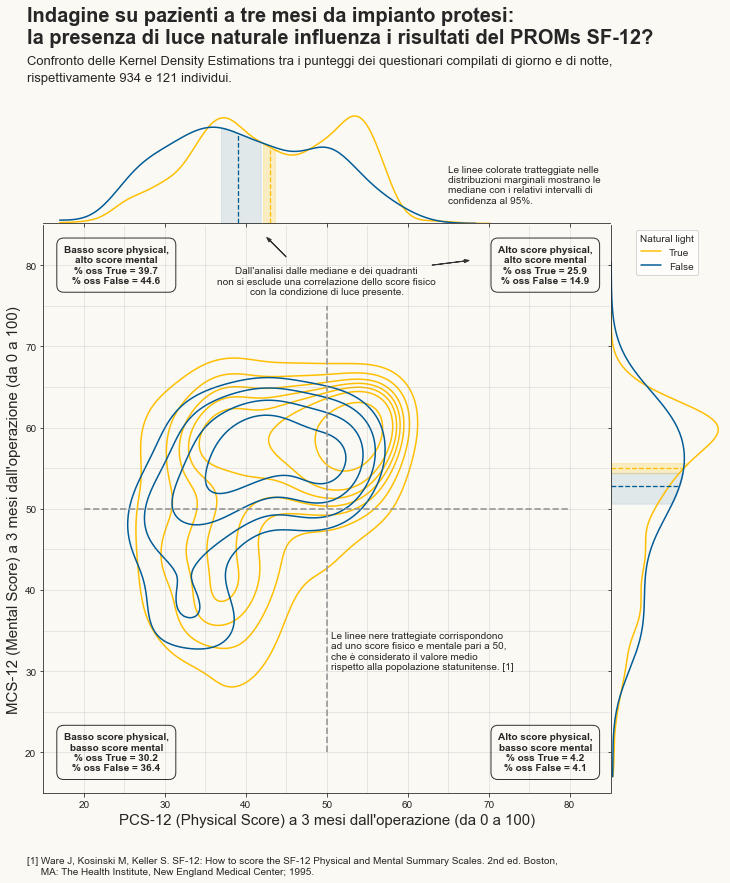

In [45]:
sns.set_style('ticks')

# Jointgrid e lo personalizzazioni
g = sns.JointGrid(height=10, space=0.01, xlim=(15,85), ylim=(15,85))
g.fig.patch.set_facecolor('#fbf9f4')
g.ax_joint.patch.set_facecolor('#fbf9f4')
g.ax_marg_x.patch.set_facecolor('#fbf9f4')
g.ax_marg_y.patch.set_facecolor('#fbf9f4')


# Griglia
linee = list(range(20, 85, 5))
for h in linee:
    g.ax_joint.axhline(y=h, color = '#999999', alpha = 0.2, lw = 1)
    g.ax_joint.axvline(x=h, color = '#999999', alpha = 0.2, lw = 1)


# Croce score 50 e 50
g.ax_joint.axvline(x=50, ymin=1/14, ymax=12/14, color = '#999999', alpha = 1, ls='--', lw = 1.7)
g.ax_joint.axhline(y=50, xmin=1/14, xmax=13/14, color = '#999999', alpha = 1, ls='--', lw = 1.7)


# Variabili colore per natural_light True e False
color_off = '#005b96'
color_on = '#ffbf00'


# Kdeplot bivariati
sns.kdeplot(x=p_on,\
            y=m_on,\
            ax=g.ax_joint,\
            thresh = 0.16,\
            levels = 8,\
            bw_adjust = 1,\
            color=color_on,\
            )


sns.kdeplot(x=p_off,\
            y=m_off,\
            ax=g.ax_joint,\
            thresh = 0.4,\
            levels = 5,\
            bw_adjust = 1,\
            color=color_off,\
            )


# Distribuzioni marginali physical
sns.kdeplot(x=p_on,\
            ax = g.ax_marg_x,\
            color=color_on,\
            bw_adjust = 0.75,\
            clip=[17,85],\
           )

sns.kdeplot(x=p_off,\
            ax = g.ax_marg_x,\
            color=color_off,\
            bw_adjust = 0.8,\
            clip=[17,85],\
           )


# Distribuzioni marginali mental
sns.kdeplot(y=m_on,\
            ax = g.ax_marg_y,\
            color=color_on,\
            bw_adjust = 0.75,\
            clip=[17,85],\
           )

sns.kdeplot(y=m_off,\
            ax = g.ax_marg_y,\
            color=color_off,\
            bw_adjust = 1.1,\
            clip=[17,85],\
           )


# Linee mediane sulle marginali
g.ax_marg_x.axvline(x=median(df1_on['physical_score_postop']), ymin=0, ymax=0.65, color = color_on, ls='--', lw = 1.3)
g.ax_marg_x.axvline(x=median(df1_off['physical_score_postop']), ymin=0, ymax=0.8, color = color_off, ls='--', lw = 1.3)
g.ax_marg_y.axhline(y=median(df1_on['mental_score_postop']), xmin=0, xmax=0.63, color = color_on, ls='--', lw = 1.3)
g.ax_marg_y.axhline(y=median(df1_off['mental_score_postop']), xmin=0, xmax=0.6, color = color_off, ls='--', lw = 1.3)


# Intervalli di confidenza sulle marginali
g.ax_marg_x.fill_between(x = x_p_on, y1 =y_p_on, where=(x_p_on >= int_p_on[0]) & (x_p_on <= int_p_on[2]), color = color_on, alpha = 0.2)
g.ax_marg_x.fill_between(x = x_p_off, y1 =y_p_off, where=(x_p_off >= int_p_off[0]) & (x_p_off <= int_p_off[2]), color = color_off, alpha = 0.1)
g.ax_marg_y.fill_betweenx(y = y_m_on, x1 =x_m_on, where=(y_m_on >= int_m_on[0]) & (y_m_on <= int_m_on[2]), color = color_on, alpha = 0.2)
g.ax_marg_y.fill_betweenx(y = y_m_off, x1 =x_m_off, where=(y_m_off >= int_m_off[0]) & (y_m_off <= int_m_off[2]), color = color_off, alpha = 0.1)


# Legenda
plt.legend(title='Natural light', labels=["True","False"], loc = 'upper center')


# Etichette assi
g.set_axis_labels('PCS-12 (Physical Score) a 3 mesi dall\'operazione (da 0 a 100)', 'MCS-12 (Mental Score) a 3 mesi dall\'operazione (da 0 a 100)', fontsize=15)


# Titolo
titolo_migliore = 'Indagine su pazienti a tre mesi da impianto protesi:\nla presenza di luce naturale influenza i risultati del PROMs SF-12?'
titolo = "La somministrazione del questionario in presenza o meno di luce\nnaturale influenza lo score fisico e mentale del SF-12 post-operatorio?"
g.fig.suptitle(
    titolo_migliore,
    x = 0.018,
    y = 1.13,
    ha="left",
    fontsize=20,
    weight="bold",
    wrap = True
)



# Sottotitolo
sottotitolo = 'Confronto delle Kernel Density Estimations tra i punteggi dei questionari compilati di giorno e di notte,\nrispettivamente 934 e 121 individui.'
g.ax_marg_x.text(13, 0.054, sottotitolo, fontsize=13, va="bottom", ha="left", linespacing = 1.5)


# Testo del context
label_croce = "Le linee nere trattegiate corrispondono\nad uno score fisico e mentale pari a 50,\nche è considerato il valore medio\nrispetto alla popolazione statunitense. [1]"
label_cit = "[1] Ware J, Kosinski M, Keller S. SF-12: How to score the SF-12 Physical and Mental Summary Scales. 2nd ed. Boston,\n     MA: The Health Institute, New England Medical Center; 1995."
label_conf = 'Le linee colorate tratteggiate nelle\ndistribuzioni marginali mostrano le\nmediane con i relativi intervalli di\nconfidenza al 95%.'
label_marg = 'Dall\'analisi dalle mediane e dei quadranti\nnon si esclude una correlazione dello score fisico\ncon la condizione di luce presente.'
label_1 = f'Alto score physical,\nalto score mental\n% oss True = {perc_on.right[0]}\n% oss False = {perc_off.right[0]}'
label_2 = f'Basso score physical,\nalto score mental\n% oss True = {perc_on.left[0]}\n% oss False = {perc_off.left[0]}'
label_3 = f'Basso score physical,\nbasso score mental\n% oss True = {perc_on.left[1]}\n% oss False = {perc_off.left[1]}'
label_4 = f'Alto score physical,\nbasso score mental\n% oss True = {perc_on.right[1]}\n% oss False = {perc_off.right[1]}'

g.ax_joint.text(50.5, 30, label_croce, fontsize=10, va="bottom", ha="left")
g.ax_joint.text(13, 6, label_cit, fontsize=10, va="center", ha='left')
g.ax_joint.text(50, 78, label_marg, fontsize=10, va="center", ha="center")
g.ax_marg_x.text(65, 0.015, label_conf, fontsize=10, va="center", ha="left")

g.ax_joint.text(77, 80, label_1, fontsize=10, va="center", ha="center", weight='bold', bbox=dict(facecolor='none', edgecolor='#333333', pad=0.7, boxstyle = 'Round'))
g.ax_joint.text(24, 80, label_2, fontsize=10, va="center", ha="center", weight='bold', bbox=dict(facecolor='none', edgecolor='#333333', pad=0.7, boxstyle = 'Round'))
g.ax_joint.text(24, 20, label_3, fontsize=10, va="center", ha="center", weight='bold', bbox=dict(facecolor='none', edgecolor='#333333', pad=0.7, boxstyle = 'Round'))
g.ax_joint.text(77, 20, label_4, fontsize=10, va="center", ha="center", weight='bold', bbox=dict(facecolor='none', edgecolor='#333333', pad=0.7, boxstyle = 'Round'))


# Frecce
g.ax_joint.arrow(45, 81, -2, 2, color = '#333333', width = 0.00001, head_width = 0.4)
g.ax_joint.arrow(63, 80, 4, 0.5, color = '#333333', width = 0.00001, head_width = 0.4)